In [1]:
from tensorflow.keras.datasets import mnist
import tensorflow as tf
import keras
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

image_dim= 28*28
noise_dim= 10

In [3]:
(x_train,y_train),(x_test,y_test)=mnist.load_data()

x_train=x_train/255
x_train=x_train.reshape(-1, image_dim)

In [6]:
def generator(ip_size, op_size):
  model= keras.models.Sequential()
  model.add(keras.layers.Dense(units=7*7, activation='tanh', input_shape=(ip_size,)))
  model.add(keras.layers.Dense(units=14*14, activation='tanh'))
  model.add(keras.layers.Dense(units=21*21, activation='tanh'))
  model.add(keras.layers.Dense(units=op_size, activation='sigmoid'))
  return model

In [7]:
def discremenetor(ip_size):
  model= keras.models.Sequential()
  model.add(keras.layers.Dense(units=1024, activation='relu', input_shape=(ip_size,)))
  model.add(keras.layers.Dense(units=256, activation='relu'))
  model.add(keras.layers.Dense(units=64, activation='relu'))
  model.add(keras.layers.Dense(units=1, activation='sigmoid'))
  opt = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

In [8]:
def generator_2(latent_dim= 100):
  model = keras.models.Sequential()
  n_nodes = 128 * 7 * 7
  model.add(keras.layers.Dense(n_nodes, input_dim= latent_dim))
  model.add(keras.layers.LeakyReLU(alpha=0.2))
  model.add(keras.layers.Reshape((7, 7, 128)))
  model.add(keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(keras.layers.LeakyReLU(alpha=0.2))
  model.add(keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(keras.layers.LeakyReLU(alpha=0.2))
  model.add(keras.layers.Conv2D(1, (7,7), activation='sigmoid', padding='same'))
  return model

In [9]:
def discremenetor_2(in_shape=(28,28,1)):
  model = keras.models.Sequential()
  model.add(keras.layers.Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
  model.add(keras.layers.LeakyReLU(alpha=0.2))
  model.add(keras.layers.Dropout(0.4))
  model.add(keras.layers.Conv2D(64, (3,3), strides=(2, 2), padding='same'))
  model.add(keras.layers.LeakyReLU(alpha=0.2))
  model.add(keras.layers.Dropout(0.4))
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(1, activation='sigmoid'))
  opt = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

In [10]:
def generate_noise(size, count=1):
  res= list()
  for _ in range(count):
    sampl = np.random.uniform(low=0.0, high=1, size=(size,))
    res.append(sampl)
  return np.array(res)


def get_n_images(n):
  res= list()
  for _ in range(n):
    index= random.randint(0, len(x_train)-1)
    res.append(x_train[index])
  return res


def unison_shuffled_copies(a, b):
  assert len(a) == len(b)
  p = np.random.permutation(len(a))
  return a[p], b[p]

In [11]:
def train_discriminator(g_model, d_model, size= 60000, epochs=1, batch_size= 1000):
  d_model.trainable= True
  half_size= int(size/2)
  real_image= get_n_images(half_size)
  real_image= np.array(real_image)
  noise= generate_noise(noise_dim, count=half_size)
  fake_image= g_model.predict(noise)
  xs= np.concatenate([real_image,fake_image])
  ys= np.concatenate([ np.ones(half_size), np.zeros(half_size) ])
  xs, ys= unison_shuffled_copies(xs, ys)
  d_model.fit(xs, ys, epochs=epochs , batch_size=batch_size )

In [12]:
def train_generator(g_model, d_model, size= 60000, epochs=1,  batch_size= 1000):
  model= keras.models.Sequential()
  d_model.trainable= False
  model.add(g_model)
  model.add(d_model)
  opt = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  xs= generate_noise(noise_dim, count=size)
  ys= np.ones(size)
  model.fit(xs, ys, epochs=epochs , batch_size=batch_size)

In [13]:
g_model= generator(noise_dim, image_dim)
d_model= discremenetor(image_dim)



	Training for  1 th time


60/60 [==============================] - 2s 31ms/step - loss: 0.0491 - accuracy: 0.9896
--------------
Epoch 1/3
60/60 [==============================] - 3s 43ms/step - loss: 1.3638 - accuracy: 0.7232
Epoch 2/3
60/60 [==============================] - 2s 39ms/step - loss: 0.0047 - accuracy: 0.9996
Epoch 3/3
1/1 [==============================] - 0s 26ms/step


	Training for  2 th time


60/60 [==============================] - 2s 31ms/step - loss: 0.0822 - accuracy: 0.9908
--------------
Epoch 1/3
60/60 [==============================] - 3s 40ms/step - loss: 0.9777 - accuracy: 0.8067
Epoch 2/3
60/60 [==============================] - 2s 40ms/step - loss: 0.0067 - accuracy: 0.9982
Epoch 3/3
1/1 [==============================] - 0s 16ms/step


	Training for  3 th time


60/60 [==============================] - 2s 34ms/step - loss: 0.0869 - accuracy: 0.9870
--------------
Epoch 1/3
60/60 [==============================] - 3s 41ms/step - loss: 0.8894 - accurac

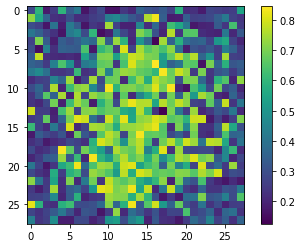

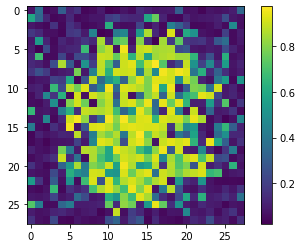

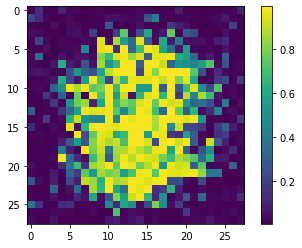

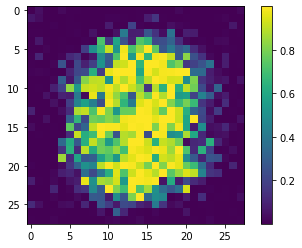

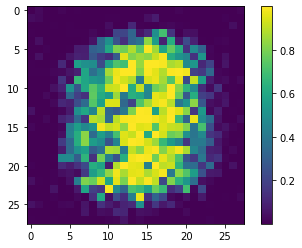

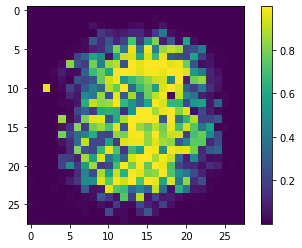

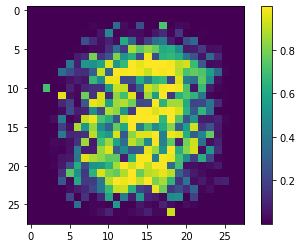

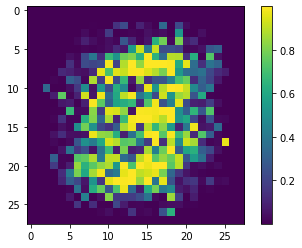

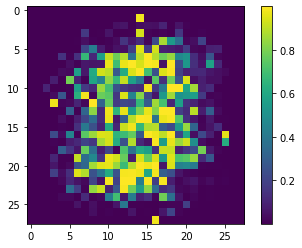

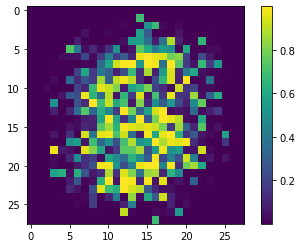

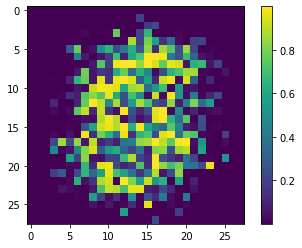

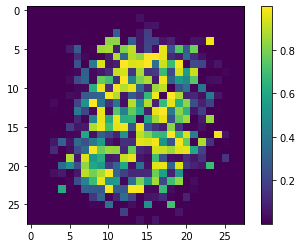

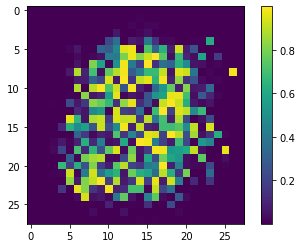

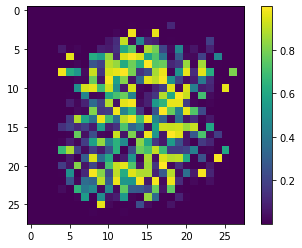

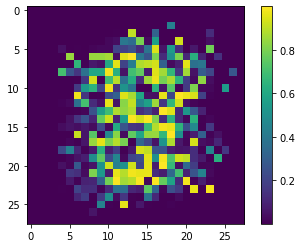

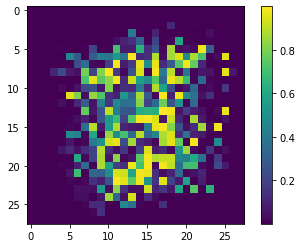

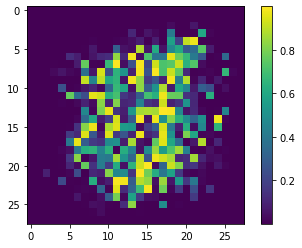

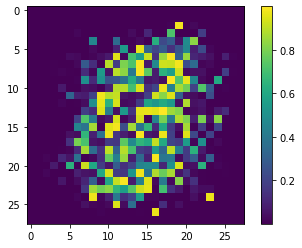

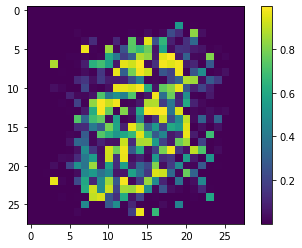

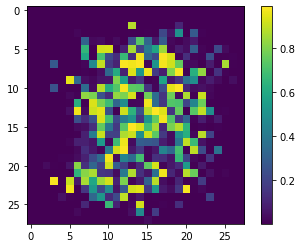

In [14]:
for i in range(20):
  print("\n\n\tTraining for ", (i+1), "th time\n\n")
  train_discriminator(g_model, d_model)
  print("--------------")
  train_generator(g_model, d_model)
  noise= generate_noise(noise_dim)
  image= g_model.predict(noise)
  draw_image(image[0])